## College Football Score Prediction - New Features & Full Analysis

This notebook incorporates high-impact line-stat features and includes the full analysis pipeline for evaluating performance and generating weekly picks.

In [1]:
# --- ✅ Configuration Cell --- #
# Set the week number here. All weekly filenames will be generated automatically.
WEEK_NUMBER = 4

In [2]:
# --- Import data --- #
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.callback import EarlyStopping
from scipy.stats import uniform, randint

# --- Load Game, S&P, and Weather Data ---
filenames = ['cfb-2025-seasonv2.csv','cfb-2024-season.csv','cfb-2023-season.csv','cfb-2022-season.csv','cfb-2021-season.csv']
all_dataframes = [pd.read_csv(f) for f in filenames if pd.io.common.file_exists(f)]
df = pd.concat(all_dataframes, ignore_index=True)
print(f"Loaded {len(all_dataframes)} season files.")

sp_filenames = ['sp_ratings_2025.csv','sp_ratings_2024.csv','sp_ratings_2023.csv','sp_ratings_2022.csv','sp_ratings_2021.csv']
all_sp_dataframes = [pd.read_csv(f) for f in sp_filenames if pd.io.common.file_exists(f)]
sp_ratings = pd.concat(all_sp_dataframes, ignore_index=True)
print("Successfully combined all S&P Ratings files.")

weather_filenames = ['game_weather_2025.csv','game_weather_2024.csv','game_weather_2023.csv','game_weather_2022.csv','game_weather_2021.csv']
all_weather_dataframes = [pd.read_csv(f) for f in weather_filenames if pd.io.common.file_exists(f)]
weather_df = pd.concat(all_weather_dataframes, ignore_index=True)
print("Successfully combined all game weather files.")

Loaded 5 season files.
Successfully combined all S&P Ratings files.
Successfully combined all game weather files.


In [3]:
# --- Clean up and Merge Data --- #

# Merge SP+ ratings for home and away teams
df = pd.merge(df, sp_ratings, left_on=['season', 'home_team'], right_on=['year', 'team'], how='left')
df.rename(columns={'sp_rating': 'home_sp_rating', 'off_sp_rating': 'home_off_sp_rating', 'def_sp_rating': 'home_def_sp_rating'}, inplace=True)
df = pd.merge(df, sp_ratings, left_on=['season', 'away_team'], right_on=['year', 'team'], how='left')
df.rename(columns={'sp_rating': 'away_sp_rating', 'off_sp_rating': 'away_off_sp_rating', 'def_sp_rating': 'away_def_sp_rating'}, inplace=True)
df.drop(columns=['year_x', 'team_x', 'year_y', 'team_y', 'special_sp_rating_x', 'special_sp_rating_y'], inplace=True, errors='ignore')

# Process and Merge Weather Data with Feature Engineering
# Select initial weather features
weather_features_df = weather_df[['game_id', 'gameIndoors', 'precipitation', 'temperature', 'windSpeed', 'weatherCondition']].copy()

# One-Hot Encode 'weatherCondition'
weather_features_df['weatherCondition_simple'] = weather_features_df['weatherCondition'].str.lower().apply(
    lambda x: 'rain' if 'rain' in str(x) else \
              ('snow' if 'snow' in str(x) else \
              ('clear' if 'clear' in str(x) or 'fair' in str(x) else 'cloudy'))
)
weather_dummies = pd.get_dummies(weather_features_df['weatherCondition_simple'], prefix='weather')
weather_features_df = weather_features_df.join(weather_dummies)

# Create Interaction and Extreme Weather Features
weather_features_df['gameIndoors'] = weather_features_df['gameIndoors'].astype(int)
weather_features_df['is_outdoor_game'] = 1 - weather_features_df['gameIndoors']
weather_features_df['is_extreme_weather'] = ((weather_features_df['windSpeed'] > 20) | (weather_features_df['precipitation'] > 0.1)).astype(int)
weather_features_df['outdoor_temp'] = weather_features_df['temperature'] * weather_features_df['is_outdoor_game']
weather_features_df['outdoor_wind'] = weather_features_df['windSpeed'] * weather_features_df['is_outdoor_game']

# Define the final list of engineered weather columns to add to the main dataframe
final_weather_cols_to_merge = [
    'game_id', 'gameIndoors', 'is_extreme_weather', 'outdoor_temp', 'outdoor_wind'
] + list(weather_dummies.columns)

# Merge the new weather features into the main dataframe
df = pd.merge(df, weather_features_df[final_weather_cols_to_merge], on='game_id', how='left')

# Basic cleaning and sorting
df['start_date'] = pd.to_datetime(df['start_date'])
df = df[df['completed'] == True].copy()
df.sort_values('start_date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert booleans to integers
df['is_conference_game'] = df['conference_game'].astype(int)
df['is_neutral_site'] = df['neutral_site'].astype(int)

In [4]:
# --- Feature creation with rolling averages (EWMA) --- #

stats_cols = [
    'off_ppa', 'off_success_rate', 'off_explosiveness', 'off_passing_ppa', 'off_rushing_ppa', 
    'off_passing_success_rate', 'off_rushing_success_rate', 
    'def_ppa', 'def_success_rate', 'def_explosiveness', 'def_passing_ppa', 'def_rushing_ppa', 
    'def_passing_success_rate', 'def_rushing_success_rate',
    'off_line_yards', 'off_stuff_rate', 'off_power_success',
    'def_line_yards', 'def_stuff_rate', 'def_power_success'
]

ewma_cols = [f'{col}_ewma' for col in stats_cols]
team_stats_ewma = {}
for col in stats_cols:
    for team_prefix in ['home_', 'away_']:
        full_col_name = team_prefix + col
        if full_col_name in df.columns:
            df[full_col_name].fillna(df[full_col_name].median(), inplace=True) 
        else:
            df[full_col_name] = 0
        df[full_col_name + '_ewma'] = np.nan
        
ewma_span = 5
for index, row in df.iterrows():
    home_team, away_team = row['home_team'], row['away_team']
    if home_team in team_stats_ewma:
        for col in stats_cols: df.loc[index, 'home_' + col + '_ewma'] = team_stats_ewma[home_team].get(col)
    if away_team in team_stats_ewma:
        for col in stats_cols: df.loc[index, 'away_' + col + '_ewma'] = team_stats_ewma[away_team].get(col)
    if home_team not in team_stats_ewma: team_stats_ewma[home_team] = {}
    if away_team not in team_stats_ewma: team_stats_ewma[away_team] = {}
    for stat_col in stats_cols:
        home_val, away_val = row['home_' + stat_col], row['away_' + stat_col]
        old_home_ewma = team_stats_ewma[home_team].get(stat_col, home_val)
        old_away_ewma = team_stats_ewma[away_team].get(stat_col, away_val)
        team_stats_ewma[home_team][stat_col] = pd.Series([old_home_ewma, home_val]).ewm(span=ewma_span, adjust=False).mean().iloc[-1]
        team_stats_ewma[away_team][stat_col] = pd.Series([old_away_ewma, away_val]).ewm(span=ewma_span, adjust=False).mean().iloc[-1]

df.dropna(subset=['home_off_ppa_ewma', 'away_off_ppa_ewma'], inplace=True)
print("Feature engineering with rolling averages complete.")

Feature engineering with rolling averages complete.


In [5]:
# --- Feature & Target Engineering --- #

df['spread'] = df['away_points'] - df['home_points']
df['total_points'] = df['home_points'] + df['away_points']

power_5_conferences = ['ACC', 'Big 12', 'Big Ten', 'Pac-12', 'SEC']
df['home_is_p5'] = df['home_conference'].isin(power_5_conferences).astype(int)
df['away_is_p5'] = df['away_conference'].isin(power_5_conferences).astype(int)
df['is_p5_matchup'] = (df['home_is_p5'] * df['away_is_p5'])

# Differential features for spread model
df['elo_diff'] = df['home_pregame_elo'] - df['away_pregame_elo']
df['sp_rating_diff'] = df['home_sp_rating'] - df['away_sp_rating']
df['off_ppa_ewma_diff'] = df['home_off_ppa_ewma'] - df['away_off_ppa_ewma']
df['def_ppa_ewma_diff'] = df['home_def_ppa_ewma'] - df['away_def_ppa_ewma']
df['line_yards_ewma_diff'] = df['home_off_line_yards_ewma'] - df['away_off_line_yards_ewma']
df['stuff_rate_ewma_diff'] = df['home_def_stuff_rate_ewma'] - df['away_def_stuff_rate_ewma']

# Aggregate features for total model
df['elo_sum'] = df['home_pregame_elo'] + df['away_pregame_elo']
df['off_ppa_ewma_sum'] = df['home_off_ppa_ewma'] + df['away_off_ppa_ewma']
df['def_ppa_ewma_sum'] = df['home_def_ppa_ewma'] + df['away_def_ppa_ewma']
df['power_success_ewma_sum'] = df['home_off_power_success_ewma'] + df['away_off_power_success_ewma']

base_feature_names = ['is_conference_game', 'is_neutral_site', 'home_is_p5', 'away_is_p5', 'is_p5_matchup']

weather_feature_names = [
    'gameIndoors', 'is_extreme_weather', 'outdoor_temp', 'outdoor_wind',
    'weather_clear', 'weather_cloudy', 'weather_rain', 'weather_snow'
]

spread_model_features = base_feature_names + [
    'elo_diff', 'sp_rating_diff', 'off_ppa_ewma_diff', 'def_ppa_ewma_diff',
    'line_yards_ewma_diff', 'stuff_rate_ewma_diff',
    'home_off_ppa_ewma', 'away_off_ppa_ewma', 'home_def_ppa_ewma', 'away_def_ppa_ewma'
]

total_model_features = base_feature_names + weather_feature_names + [
    'elo_sum', 'off_ppa_ewma_sum', 'def_ppa_ewma_sum', 'power_success_ewma_sum',
    'home_off_ppa_ewma', 'away_off_ppa_ewma', 'home_def_ppa_ewma', 'away_def_ppa_ewma'
]

X_spread = df[spread_model_features].copy()
X_total = df[total_model_features].copy()
y_spread = df['spread']
y_total = df['total_points']

X_spread.fillna(X_spread.median(), inplace=True)
X_total.fillna(X_total.median(), inplace=True)
print("Created separate feature sets for spread and total points models.")

Created separate feature sets for spread and total points models.


In [6]:
# --- Train & Test with Hyperparameter Tuning & Feature Importance --- #

# Chronological train-test split
split_index = int(len(df) * 0.85)
X_spread_train, X_spread_test = X_spread[:split_index], X_spread[split_index:]
X_total_train, X_total_test = X_total[:split_index], X_total[split_index:]
y_spread_train, y_spread_test = y_spread[:split_index], y_spread[split_index:]
y_total_train, y_total_test = y_total[:split_index], y_total[split_index:]

y_total_train_log = np.log1p(y_total_train)

# Define parameter distribution for RandomizedSearch
param_dist = {
    'n_estimators': randint(300, 1500),
    'learning_rate': uniform(0.01, 0.04),
    'max_depth': randint(3, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 5]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42, early_stopping_rounds=30)

# --- Tune and Train Spread Model --- #
print("Tuning Spread Model...")
rs_spread = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=60, cv=3, verbose=0, random_state=42)
rs_spread.fit(X_spread_train, y_spread_train, eval_set=[(X_spread_test, y_spread_test)], verbose=False)
xgb_spread = rs_spread.best_estimator_

print(f"Best Spread Params: {rs_spread.best_params_}")

# --- NEW: Display Feature Importances for Spread Model --- #
spread_importances = pd.DataFrame({
    'feature': X_spread_train.columns,
    'importance': xgb_spread.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\\n--- Spread Model Feature Importance ---")
print("(The model uses all features, but those with higher importance have a greater impact on predictions)")
print(spread_importances)


# --- Tune and Train Total Model --- #
print("\n\nTuning Total Points Model...")
rs_total = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=60, cv=3, verbose=0, random_state=42)
rs_total.fit(X_total_train, y_total_train_log, eval_set=[(X_total_test, np.log1p(y_total_test))], verbose=False)
xgb_total = rs_total.best_estimator_

print(f"Best Total Params: {rs_total.best_params_}")

# --- Display Feature Importances for Total Model --- #
total_importances = pd.DataFrame({
    'feature': X_total_train.columns,
    'importance': xgb_total.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\\n--- Total Points Model Feature Importance ---")
print("(The model uses all features, but those with higher importance have a greater impact on predictions)")
print(total_importances)

Tuning Spread Model...
Best Spread Params: {'colsample_bytree': 0.7678400249711159, 'gamma': 1, 'learning_rate': 0.032641488419763054, 'max_depth': 5, 'n_estimators': 1296, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7367518666865607}
\n--- Spread Model Feature Importance ---
(The model uses all features, but those with higher importance have a greater impact on predictions)
                 feature  importance
0         sp_rating_diff    0.240718
1     is_conference_game    0.125377
2             home_is_p5    0.123073
3             away_is_p5    0.078806
4          is_p5_matchup    0.070567
5               elo_diff    0.059101
6      off_ppa_ewma_diff    0.051347
7   line_yards_ewma_diff    0.038448
8      def_ppa_ewma_diff    0.035990
9      home_off_ppa_ewma    0.033728
10     away_off_ppa_ewma    0.032489
11     home_def_ppa_ewma    0.030357
12     away_def_ppa_ewma    0.028276
13       is_neutral_site    0.028173
14  stuff_rate_ewma_diff    0.023549


Tuning Total Points 


--- Final Model Evaluation ---

Home Points Model Evaluation:
RMSE: 12.6623
R-squared: 0.3052

Away Points Model Evaluation:
RMSE: 10.5651
R-squared: 0.3171


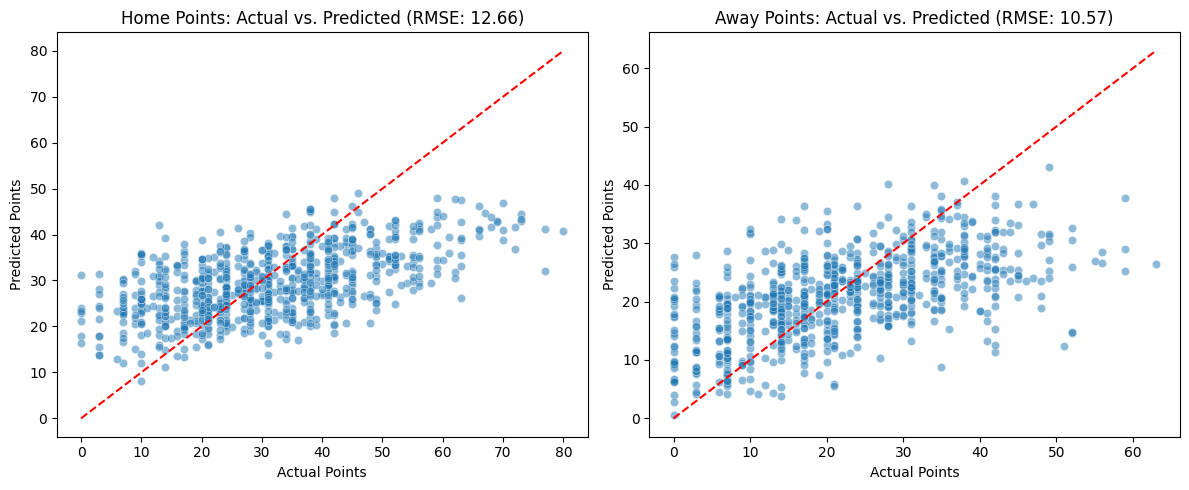

In [7]:
# --- Evaluate New Models --- #

spread_preds = xgb_spread.predict(X_spread_test)
total_preds_log = xgb_total.predict(X_total_test)
total_preds = np.expm1(total_preds_log)

pred_home_scores = (total_preds - spread_preds) / 2
pred_away_scores = (total_preds + spread_preds) / 2

actual_home_scores = df.iloc[split_index:]['home_points']
actual_away_scores = df.iloc[split_index:]['away_points']

home_rmse = np.sqrt(mean_squared_error(actual_home_scores, pred_home_scores))
home_r2 = r2_score(actual_home_scores, pred_home_scores)
away_rmse = np.sqrt(mean_squared_error(actual_away_scores, pred_away_scores))
away_r2 = r2_score(actual_away_scores, pred_away_scores)

print("\n--- Final Model Evaluation ---")
print("\nHome Points Model Evaluation:")
print(f"RMSE: {home_rmse:.4f}")
print(f"R-squared: {home_r2:.4f}")

print("\nAway Points Model Evaluation:")
print(f"RMSE: {away_rmse:.4f}")
print(f"R-squared: {away_r2:.4f}")

# Visualize predictions vs actuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=actual_home_scores, y=pred_home_scores, alpha=0.5)
plt.plot([actual_home_scores.min(), actual_home_scores.max()], [actual_home_scores.min(), actual_home_scores.max()], color='red', linestyle='--') 
plt.title(f'Home Points: Actual vs. Predicted (RMSE: {home_rmse:.2f})')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

plt.subplot(1, 2, 2)
sns.scatterplot(x=actual_away_scores, y=pred_away_scores, alpha=0.5)
plt.plot([actual_away_scores.min(), actual_away_scores.max()], [actual_away_scores.min(), actual_away_scores.max()], color='red', linestyle='--')
plt.title(f'Away Points: Actual vs. Predicted (RMSE: {away_rmse:.2f})')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.tight_layout()
plt.show()

### Note on Runtime Warnings
The following cell calculates the model's performance against betting lines. You may see a `RuntimeWarning: Mean of empty slice`. This is expected. It occurs for games in the test set that have no betting data available (e.g., FCS games). The code correctly produces a `NaN` for these averages, and these games are filtered out before the final analysis, so the warning can be safely ignored.

In [8]:
# --- Combined Team Performance Analysis ---

results_df = df.iloc[split_index:].copy()
results_df['actual_home_pts'] = actual_home_scores.values
results_df['predicted_home_pts'] = pred_home_scores
results_df['actual_away_pts'] = actual_away_scores.values
results_df['predicted_away_pts'] = pred_away_scores

results_df['home_error'] = abs(results_df['actual_home_pts'] - results_df['predicted_home_pts'])
results_df['away_error'] = abs(results_df['actual_away_pts'] - results_df['predicted_away_pts'])

home_errors = results_df[['home_team', 'home_error']].rename(columns={'home_team': 'team', 'home_error': 'error'})
away_errors = results_df[['away_team', 'away_error']].rename(columns={'away_team': 'team', 'away_error': 'error'})
all_team_errors = pd.concat([home_errors, away_errors], ignore_index=True)

team_accuracy_summary = all_team_errors.groupby('team')['error'].agg(
    average_prediction_error='mean',
    games_played='count'
).reset_index()

results_df['actual_total'] = results_df['actual_home_pts'] + results_df['actual_away_pts']
results_df['actual_spread'] = results_df['actual_away_pts'] - results_df['actual_home_pts'] # Using away-home to match model
results_df['predicted_total'] = total_preds
results_df['predicted_spread'] = spread_preds

results_df['model_total_error'] = abs(results_df['predicted_total'] - results_df['actual_total'])
results_df['model_spread_error'] = abs(results_df['predicted_spread'] - results_df['actual_spread'])

results_df['avg_bookie_total_error'] = results_df[['espn_over_under', 'draftkings_over_under', 'bovada_over_under']].sub(results_df['actual_total'], axis=0).abs().mean(axis=1)
results_df['avg_bookie_spread_error'] = results_df[['espn_spread', 'draftkings_spread', 'bovada_spread']].sub(results_df['actual_spread'], axis=0).abs().mean(axis=1)

results_df['improvement_vs_total'] = results_df['avg_bookie_total_error'] - results_df['model_total_error']
results_df['improvement_vs_spread'] = results_df['avg_bookie_spread_error'] - results_df['model_spread_error']

home_improvement = results_df[['home_team', 'improvement_vs_total', 'improvement_vs_spread']].rename(columns={'home_team': 'team'})
away_improvement = results_df[['away_team', 'improvement_vs_total', 'improvement_vs_spread']].rename(columns={'away_team': 'team'})
all_team_improvement = pd.concat([home_improvement, away_improvement], ignore_index=True)

team_improvement_summary = all_team_improvement.groupby('team').agg(
    avg_improvement_vs_total=('improvement_vs_total', 'mean'),
    avg_improvement_vs_spread=('improvement_vs_spread', 'mean')
).reset_index()
team_improvement_summary['combined_improvement'] = team_improvement_summary['avg_improvement_vs_total'] + team_improvement_summary['avg_improvement_vs_spread']

combined_summary_df = pd.merge(team_accuracy_summary, team_improvement_summary, on='team')
combined_summary_df_sorted = combined_summary_df.sort_values(by=['average_prediction_error', 'combined_improvement'], ascending=[True, False])

output_filename = 'all_teams_performance_summary.csv'
csv_columns = ['team', 'games_played', 'average_prediction_error', 'combined_improvement', 'avg_improvement_vs_spread', 'avg_improvement_vs_total']
combined_summary_df_sorted[csv_columns].round(2).to_csv(output_filename, index=False)
print(f"Full performance summary for all teams saved to '{output_filename}'")

Full performance summary for all teams saved to 'all_teams_performance_summary.csv'


In [9]:
# --- Predicting Future Games ---
print("--- Starting Week Predictions ---")

# Define filenames using the WEEK_NUMBER variable
future_games_file = f'cfb_week{WEEK_NUMBER}_predictions_empty.csv'
all_predictions_output_file = f'cfb_week{WEEK_NUMBER}_all_predictions.csv'

try:
    df_future = pd.read_csv(future_games_file)
    print(f"Successfully loaded {len(df_future)} future games to predict from {future_games_file}.")
except FileNotFoundError:
    print(f"Error: '{future_games_file}' not found.")
    df_future = None

if df_future is not None:
    # --- Replicate feature engineering on future data ---
    df_future['is_conference_game'] = df_future['conference_game'].astype(int)
    df_future['is_neutral_site'] = df_future['neutral_site'].astype(int)
    for col in ewma_cols:
        df_future['home_' + col] = np.nan; df_future['away_' + col] = np.nan
    for index, row in df_future.iterrows():
        home_team, away_team = row['home_team'], row['away_team']
        home_stats, away_stats = team_stats_ewma.get(home_team, {}), team_stats_ewma.get(away_team, {})
        for i, stat_col in enumerate(stats_cols):
            df_future.loc[index, 'home_' + ewma_cols[i]] = home_stats.get(stat_col)
            df_future.loc[index, 'away_' + ewma_cols[i]] = away_stats.get(stat_col)
    
    df_future = pd.merge(df_future, sp_ratings, left_on=['season', 'home_team'], right_on=['year', 'team'], how='left')
    df_future.rename(columns={'sp_rating': 'home_sp_rating', 'off_sp_rating': 'home_off_sp_rating', 'def_sp_rating': 'home_def_sp_rating'}, inplace=True)
    df_future = pd.merge(df_future, sp_ratings, left_on=['season', 'away_team'], right_on=['year', 'team'], how='left')
    df_future.rename(columns={'sp_rating': 'away_sp_rating', 'off_sp_rating': 'away_off_sp_rating', 'def_sp_rating': 'away_def_sp_rating'}, inplace=True)
    df_future.drop(columns=['year_x', 'team_x', 'year_y', 'team_y', 'special_sp_rating_x', 'special_sp_rating_y'], inplace=True, errors='ignore')
    df_future = pd.merge(df_future, weather_features_df, on='game_id', how='left')

    df_future['home_is_p5'] = df_future['home_conference'].isin(power_5_conferences).astype(int)
    df_future['away_is_p5'] = df_future['away_conference'].isin(power_5_conferences).astype(int)
    df_future['is_p5_matchup'] = (df_future['home_is_p5'] * df_future['away_is_p5'])
    df_future['elo_diff'] = df_future['home_pregame_elo'] - df_future['away_pregame_elo']
    df_future['sp_rating_diff'] = df_future['home_sp_rating'] - df_future['away_sp_rating']
    df_future['off_ppa_ewma_diff'] = df_future['home_off_ppa_ewma'] - df_future['away_off_ppa_ewma']
    df_future['def_ppa_ewma_diff'] = df_future['home_def_ppa_ewma'] - df_future['away_def_ppa_ewma']
    df_future['line_yards_ewma_diff'] = df_future['home_off_line_yards_ewma'] - df_future['away_off_line_yards_ewma']
    df_future['stuff_rate_ewma_diff'] = df_future['home_def_stuff_rate_ewma'] - df_future['away_def_stuff_rate_ewma']
    df_future['elo_sum'] = df_future['home_pregame_elo'] + df_future['away_pregame_elo']
    df_future['off_ppa_ewma_sum'] = df_future['home_off_ppa_ewma'] + df_future['away_off_ppa_ewma']
    df_future['def_ppa_ewma_sum'] = df_future['home_def_ppa_ewma'] + df_future['away_def_ppa_ewma']
    df_future['power_success_ewma_sum'] = df_future['home_off_power_success_ewma'] + df_future['away_off_power_success_ewma']
    
    X_future_spread = df_future[spread_model_features].copy().fillna(0)
    X_future_total = df_future[total_model_features].copy().fillna(0)

    future_spread_preds = xgb_spread.predict(X_future_spread)
    future_total_preds_log = xgb_total.predict(X_future_total)
    future_total_preds = np.expm1(future_total_preds_log)
    
    future_home_scores = (future_total_preds - future_spread_preds) / 2
    future_away_scores = (future_total_preds + future_spread_preds) / 2

    predictions_df = pd.DataFrame({
        'Home_Team': df_future['home_team'], 'Away_Team': df_future['away_team'],
        'Predicted_Home_Points': future_home_scores.round(1), 'Predicted_Away_Points': future_away_scores.round(1)
    })
    
    home_games = df['home_team'].value_counts()
    away_games = df['away_team'].value_counts()
    historical_game_counts = home_games.add(away_games, fill_value=0).astype(int)
    predictions_df['Home_Team_Games'] = predictions_df['Home_Team'].map(historical_game_counts).fillna(0).astype(int)
    predictions_df['Away_Team_Games'] = predictions_df['Away_Team'].map(historical_game_counts).fillna(0).astype(int)

    print(f"Writing week {WEEK_NUMBER} predictions to {all_predictions_output_file}")
    predictions_df.round(2).to_csv(all_predictions_output_file, index=False)

--- Starting Week Predictions ---
Successfully loaded 301 future games to predict from cfb_week4_predictions_empty.csv.
Writing week 4 predictions to cfb_week4_all_predictions.csv


In [10]:
# --- Comparing Predictions to Betting Lines ---

# Define filename using the WEEK_NUMBER variable
prediction_vs_lines_output_file = f'cfb_week{WEEK_NUMBER}_prediction_vs_lines.csv'

if df_future is not None:
    comparison_df = df_future.copy()
    comparison_df['predicted_home_pts'] = predictions_df['Predicted_Home_Points']
    comparison_df['predicted_away_pts'] = predictions_df['Predicted_Away_Points']
    comparison_df['predicted_total'] = comparison_df['predicted_home_pts'] + comparison_df['predicted_away_pts']
    comparison_df['predicted_spread'] = comparison_df['predicted_away_pts'] - comparison_df['predicted_home_pts']
    
    spread_cols = ['espn_spread', 'draftkings_spread', 'bovada_spread']
    over_under_cols = ['espn_over_under', 'draftkings_over_under', 'bovada_over_under']
    comparison_df['avg_line_spread'] = comparison_df[spread_cols].mean(axis=1)
    comparison_df['avg_line_over_under'] = comparison_df[over_under_cols].mean(axis=1)
    comparison_df['spread_difference'] = abs(comparison_df['predicted_spread'] - comparison_df['avg_line_spread'])
    comparison_df['total_difference'] = abs(comparison_df['predicted_total'] - comparison_df['avg_line_over_under'])
    comparison_df['combined_difference'] = comparison_df['spread_difference'] + comparison_df['total_difference']
    
    final_comparison = comparison_df.dropna(subset=['avg_line_spread', 'avg_line_over_under']).copy()
    top_differences = final_comparison.sort_values(by='combined_difference', ascending=False)
    
    top_differences['home_team_games_played'] = top_differences['home_team'].map(historical_game_counts).fillna(0).astype(int)
    top_differences['away_team_games_played'] = top_differences['away_team'].map(historical_game_counts).fillna(0).astype(int)
    
    output_cols = ['home_team', 'home_team_games_played', 'away_team', 'away_team_games_played', 'predicted_spread', 'predicted_total', 'espn_spread', 
                   'draftkings_spread', 'bovada_spread', 'espn_over_under', 'draftkings_over_under', 'bovada_over_under', 
                   'spread_difference', 'total_difference', 'combined_difference']
    
    print(f"Writing predictions vs. available spreads to {prediction_vs_lines_output_file}")
    top_differences[output_cols].round(2).to_csv(prediction_vs_lines_output_file, index=False)

Writing predictions vs. available spreads to cfb_week4_prediction_vs_lines.csv


In [11]:
# --- Calculate Pick Score --- #

# Define filenames using the WEEK_NUMBER variable
detailed_comparison_file = f'cfb_week{WEEK_NUMBER}_prediction_vs_lines.csv'
best_picks_output_file = f'best_potential_picks_week{WEEK_NUMBER}.csv'

if df_future is not None and not top_differences.empty:
    detailed_comparison = pd.read_csv(detailed_comparison_file)
    performance_summary = pd.read_csv('all_teams_performance_summary.csv')

    home_performance = performance_summary.add_prefix('home_')
    merged_data = pd.merge(detailed_comparison, home_performance, left_on='home_team', right_on='home_team', how='left')
    away_performance = performance_summary.add_prefix('away_')
    merged_data = pd.merge(merged_data, away_performance, left_on='away_team', right_on='away_team', how='left')

    merged_data['pick_score'] = merged_data['combined_difference'] / (merged_data['home_average_prediction_error'] + merged_data['away_average_prediction_error'] + 1)
    best_picks = merged_data.sort_values(by='pick_score', ascending=False)

    output_columns = [
        'home_team', 'away_team', 'predicted_spread', 'espn_spread', 'draftkings_spread', 'bovada_spread',
        'predicted_total', 'espn_over_under', 'draftkings_over_under', 'bovada_over_under',
        'combined_difference', 'home_average_prediction_error', 'away_average_prediction_error', 'pick_score'
    ]
    best_picks_output = best_picks[output_columns].round(2)
    best_picks_output.to_csv(best_picks_output_file, index=False)
    
    print(f"'{best_picks_output_file}' has been created with the full ranked list.")

'best_potential_picks_week4.csv' has been created with the full ranked list.
